MTCNN算法是一种基于深度学习的人脸检测和人脸对齐方法，它可以同时完成人脸检测和人脸对齐的任务，相比于传统的算法，它的性能更好，检测速度更快。

MTCNN算法包含三个子网络：Proposal Network(P-Net)、Refine Network(R-Net)、Output Network(O-Net)，这三个网络对人脸的处理依次从粗到细。

在使用这三个子网络之前，**需要使用图像金字塔将原始图像缩放到不同的尺度**，然后将不同尺度的图像送入这三个子网络中进行训练，目的是为了可以检测到不同大小的人脸，从而实现多尺度目标检测。

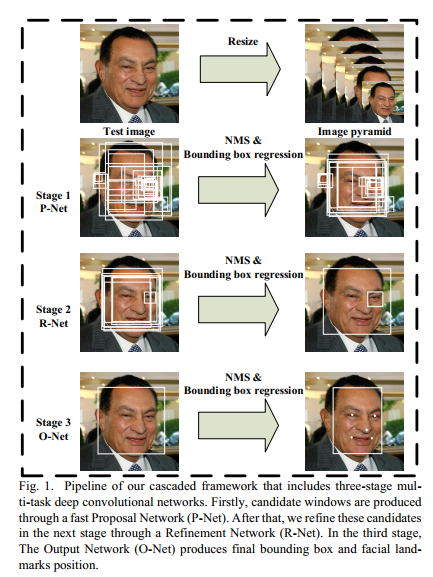

# P-Net

P-Net的主要目的是为了生成一些候选框，我们通过使用P-Net网络，对图像金字塔图像上不同尺度下的图像的每一个12×12区域都做一个人脸检测(实际上在使用卷积网络实现时，一般会把一张h×w的图像送入P-Net中，最终得到的特征图每一点都对应着一个大小为12×12的感受野，但是并没有遍历全一张图像每一个12×12的图像)。

P-Net的输入是一个12×12×3的RGB图像，在训练的时候，该网络要判断这个12×12的图像中是否存在人脸，并且给出人脸框的回归和人脸关键点定位；

在测试的时候输出只有N个边界框的4个坐标信息和score，当然这4个坐标信息已经使用网络的人脸框回归进行校正过了，score可以看做是分类的输出(即人脸的概率)：

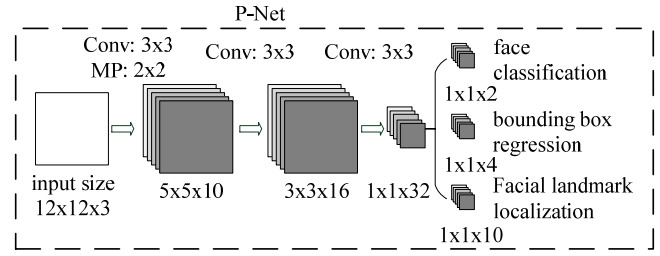

- 网络的第一部分输出是用来判断该图像是否包含人脸，输出向量大小为1×1×2，也就是两个值，即图像是人脸的概率和图像不是人脸的概率。这两个值加起来严格等于1，之所以使用两个值来表示，是为了方便定义交叉熵损失函数。
- 网络的第二部分给出框的精确位置，一般称为框回归。P-Net输入的12×12的图像块可能并不是完美的人脸框的位置，如有的时候人脸并不正好为方形，有可能12×12的图像偏左或偏右，因此需要输出当前框位置相对完美的人脸框位置的偏移。这个偏移大小为1×1×4，即表示框左上角的横坐标的相对偏移，框左上角的纵坐标的相对偏移、框的宽度的误差、框的高度的误差。
- 网络的第三部分给出人脸的5个关键点的位置。5个关键点分别对应着左眼的位置、右眼的位置、鼻子的位置、左嘴巴的位置、右嘴巴的位置。每个关键点需要两维来表示，因此输出是向量大小为1×1×10。

In [ ]:
import tensorflow as tf
slim=tf.contrib.slim
import numpy as np
#只把70%数据用作参数更新
num_keep_radio=0.7

def prelu(inputs):
    '''prelu函数定义'''
    alphas=tf.get_variable('alphas',shape=inputs.get_shape()[-1],dtype=tf.float32,
                          initializer=tf.constant_initializer(0.25))
    pos=tf.nn.relu(inputs)
    neg=alphas*(inputs-abs(inputs))*0.5
    return pos+neg

def cal_accuracy(cls_prob,label):
    '''计算分类准确率'''
    #预测最大概率的类别，0代表无人，1代表有人
    pred=tf.argmax(cls_prob,axis=1)
    label_int=tf.cast(label,tf.int64)
    #保留label>=0的数据，即pos和neg的数据
    cond=tf.where(tf.greater_equal(label_int,0))
    picked=tf.squeeze(cond)
    #获取pos和neg的label值
    label_picked=tf.gather(label_int,picked)
    pred_picked=tf.gather(pred,picked)
    #计算准确率
    accuracy_op=tf.reduce_mean(tf.cast(tf.equal(label_picked,pred_picked),tf.float32))
    return accuracy_op

def P_Net(inputs,label=None,bbox_target=None,landmark_target=None,training=True):
    '''pnet的结构'''
    with tf.variable_scope('PNet'):
        with slim.arg_scope([slim.conv2d],activation_fn=prelu,
                           weights_initializer=slim.xavier_initializer(),
                           weights_regularizer=slim.l2_regularizer(0.0005),
                           padding='VALID'):
            net=slim.conv2d(inputs,10,3,scope='conv1')
            net=slim.max_pool2d(net,kernel_size=[2,2],stride=2,padding='SAME',scope='pool1')
            net=slim.conv2d(net,16,3,scope='conv2')
            net=slim.conv2d(net,32,3,scope='conv3')
            #二分类输出通道数为2
            conv4_1=slim.conv2d(net,2,1,activation_fn=tf.nn.softmax,scope='conv4_1')
            bbox_pred=slim.conv2d(net,4,1,activation_fn=None,scope='conv4_2')
            landmark_pred=slim.conv2d(net,10,1,activation_fn=None,scope='conv4_3')
            
            if training:
                cls_prob=tf.squeeze(conv4_1,[1,2],name='cls_prob')#[batch,2]
                cls_loss=cls_ohem(cls_prob,label)
                
                bbox_pred=tf.squeeze(bbox_pred,[1,2],name='bbox_pred')#[bacth,4]
                bbox_loss=bbox_ohem(bbox_pred,bbox_target,label)
                
                landmark_pred=tf.squeeze(landmark_pred,[1,2],name='landmark_pred')#[batch,10]
                landmark_loss=landmark_ohem(landmark_pred,landmark_target,label)
                
                accuracy=cal_accuracy(cls_prob,label)
                L2_loss=tf.add_n(slim.losses.get_regularization_losses())
                return cls_loss,bbox_loss,landmark_loss,L2_loss,accuracy
            else:
                #测试时batch_size=1
                cls_pro_test=tf.squeeze(conv4_1,axis=0)
                bbox_pred_test=tf.squeeze(bbox_pred,axis=0)
                landmark_pred_test=tf.squeeze(landmark_pred,axis=0)
                return cls_pro_test,bbox_pred_test,landmark_pred_test

# R-Net

由于P-Net的检测时比较粗略的，所以接下来使用R-Net进一步优化。R-Net和P-Net类似，不过这一步的输入是前面P-Net生成的边界框，不管实际边界框的大小，在输入R-Net之前，都需要缩放到24×24×3。网络的输出和P-Net是一样的。这一步的目的主要是为了去除大量的非人脸框。

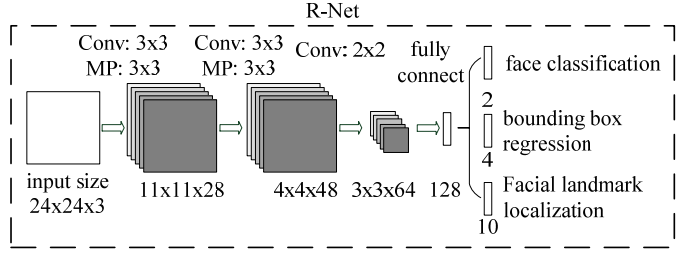

In [ ]:
def R_Net(inputs,label=None,bbox_target=None,landmark_target=None,training=True):
    '''RNet结构'''
    with tf.variable_scope('RNet'):
        with slim.arg_scope([slim.conv2d],
                           activation_fn=prelu,
                           weights_initializer=slim.xavier_initializer(),
                           weights_regularizer=slim.l2_regularizer(0.0005),
                           padding='VALID'):
            net=slim.conv2d(inputs,28,3,scope='conv1')
            net=slim.max_pool2d(net,kernel_size=[3,3],stride=2,padding='SAME',scope='pool1')
            net=slim.conv2d(net,48,3,scope='conv2')
            net=slim.max_pool2d(net,kernel_size=[3,3],stride=2,scope='pool2')
            net=slim.conv2d(net,64,2,scope='conv3')
            fc_flatten=slim.flatten(net)
            fc1=slim.fully_connected(fc_flatten,num_outputs=128,scope='fc1')
            
            cls_prob=slim.fully_connected(fc1,num_outputs=2,activation_fn=tf.nn.softmax,scope='cls_fc')
            bbox_pred=slim.fully_connected(fc1,num_outputs=4,activation_fn=None,scope='bbox_fc')
            landmark_pred=slim.fully_connected(fc1,num_outputs=10,activation_fn=None,scope='landmark_fc')
            if training:
                cls_loss=cls_ohem(cls_prob,label)
                
                bbox_loss=bbox_ohem(bbox_pred,bbox_target,label)
                
                landmark_loss=landmark_ohem(landmark_pred,landmark_target,label)
                
                accuracy=cal_accuracy(cls_prob,label)
                L2_loss=tf.add_n(slim.losses.get_regularization_losses())
                return cls_loss,bbox_loss,landmark_loss,L2_loss,accuracy
            else:
                return cls_prob,bbox_pred,landmark_pred

# O-Net

进一步将R-Net的所得到的区域缩放到48×48×3，输入到最后的O-Net，O-Net的结构与P-Net类似，只不过在测试输出的时候多了关键点位置的输出。输入大小为48×48×3的图像，输出包含P个边界框的坐标信息，score以及关键点位置。

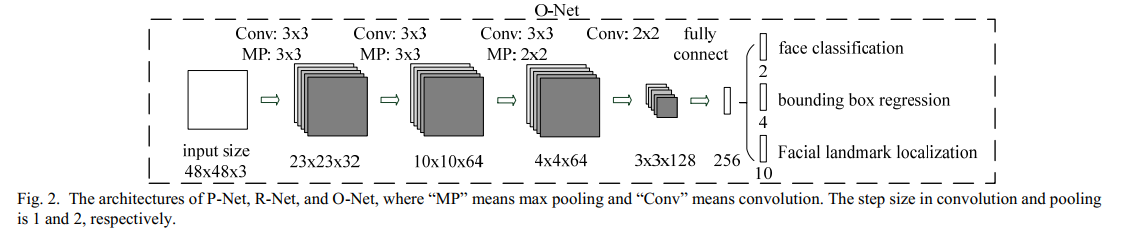

从P-Net到R-Net，再到最后的O-Net，网络输入的图像越来越大，卷积层的通道数越来越多，网络的深度也越来越深，因此识别人脸的准确率应该也是越来越高的。同时P-Net网络的运行速度越快，R-Net次之、O-Net运行速度最慢。之所以使用三个网络，是因为一开始如果直接对图像使用O-Net网络，速度会非常慢。实际上P-Net先做了一层过滤，将过滤后的结果再交给R-Net进行过滤，最后将过滤后的结果交给效果最好但是速度最慢的O-Net进行识别。这样在每一步都提前减少了需要判别的数量，有效地降低了计算的时间。

In [ ]:
def O_Net(inputs,label=None,bbox_target=None,landmark_target=None,training=True):
    '''ONet结构'''
    with tf.variable_scope('ONet'):
        with slim.arg_scope([slim.conv2d],
                           activation_fn=prelu,
                           weights_initializer=slim.xavier_initializer(),
                           weights_regularizer=slim.l2_regularizer(0.0005),
                           padding='VALID'):
            net=slim.conv2d(inputs,32,3,scope='conv1')
            net=slim.max_pool2d(net,kernel_size=[3,3],stride=2,padding='SAME',scope='pool1')
            net=slim.conv2d(net,64,3,scope='conv2')
            net=slim.max_pool2d(net,kernel_size=[3,3],stride=2,scope='pool2')
            net=slim.conv2d(net,64,3,scope='conv3')
            net=slim.max_pool2d(net,kernel_size=[2,2],stride=2,padding='SAME',scope='pool3')
            net=slim.conv2d(net,128,2,scope='conv4')
            fc_flatten=slim.flatten(net)
            fc1=slim.fully_connected(fc_flatten,num_outputs=256,scope='fc1')
            
            cls_prob=slim.fully_connected(fc1,num_outputs=2,activation_fn=tf.nn.softmax,scope='cls_fc')
            bbox_pred=slim.fully_connected(fc1,num_outputs=4,activation_fn=None,scope='bbox_fc')
            landmark_pred=slim.fully_connected(fc1,num_outputs=10,activation_fn=None,scope='landmark_fc')
            if training:
                cls_loss=cls_ohem(cls_prob,label)
                
                bbox_loss=bbox_ohem(bbox_pred,bbox_target,label)
                
                landmark_loss=landmark_ohem(landmark_pred,landmark_target,label)
                
                accuracy=cal_accuracy(cls_prob,label)
                L2_loss=tf.add_n(slim.losses.get_regularization_losses())
                return cls_loss,bbox_loss,landmark_loss,L2_loss,accuracy
            else:
                return cls_prob,bbox_pred,landmark_pred

# MTCNN损失函数

由于MTCNN包含三个子网络，因此其损失函数也由三部分组成。
- 针对人脸识别问题，直接使用交叉熵代价函数，
- 对于框回归和关键点定位，使用L2损失。

最后把这三部分的损失各自乘以自身的权重累加起来，形成最后的总损失。

在训练P-Net和R-Net的时候，我们主要关注目标框的准确度，而较少关注关键点判定的损失，因此关键点损失所占的权重较小。对于O-Net，比较关注的是关键点的位置，因此关键点损失所占的权重就会比较大。

## 人脸识别损失函数

$$L_i^{det}=-(y_i^{det}\log(p_i)+(1-y^{det}_i)(1-\log(p_i))$$

其中$y_i^{det}$表示样本的真实标签，$p_i$表示网络输出为人脸的概率

In [ ]:
def cls_ohem(cls_prob,label):
    '''计算类别损失
    参数：
      cls_prob：预测类别，是否有人
      label：真实值
    返回值：
      损失
    '''
    zeros=tf.zeros_like(label)
    #只把pos的label设定为1,其余都为0
    label_filter_invalid=tf.where(tf.less(label,0),zeros,label)
    #类别size[2*batch]
    num_cls_prob=tf.size(cls_prob)
    cls_prob_reshpae=tf.reshape(cls_prob,[num_cls_prob,-1])
    label_int=tf.cast(label_filter_invalid,tf.int32)
    #获取batch数
    num_row=tf.to_int32(cls_prob.get_shape()[0])
    #对应某一batch而言，batch*2为非人类别概率，batch*2+1为人概率类别,indices为对应 cls_prob_reshpae
    #应该的真实值，后续用交叉熵计算损失
    row=tf.range(num_row)*2
    indices_=row+label_int
    #真实标签对应的概率
    label_prob=tf.squeeze(tf.gather(cls_prob_reshpae,indices_))
    loss=-tf.log(label_prob+1e-10)
    zeros=tf.zeros_like(label_prob,dtype=tf.float32)
    ones=tf.ones_like(label_prob,dtype=tf.float32)
    #统计neg和pos的数量
    valid_inds=tf.where(label<zeros,zeros,ones)
    num_valid=tf.reduce_sum(valid_inds)
    #选取70%的数据
    keep_num=tf.cast(num_valid*num_keep_radio,dtype=tf.int32)
    #只选取neg，pos的70%损失
    loss=loss*valid_inds
    loss,_=tf.nn.top_k(loss,k=keep_num)
    return tf.reduce_mean(loss)

## 框回归

对于目标框的回归，我们采用的是欧氏距离

$$L_i^{box}=||\hat{y}_i^{box}-y_i^{box}||$$

其中$\hat{y}_i^{box}$表示网络输出的边界框坐标，$y_i^{box}$是真实边界框

In [ ]:
def bbox_ohem(bbox_pred,bbox_target,label):
    '''计算box的损失'''
    zeros_index=tf.zeros_like(label,dtype=tf.float32)
    ones_index=tf.ones_like(label,dtype=tf.float32)
    #保留pos和part的数据
    valid_inds=tf.where(tf.equal(tf.abs(label),1),ones_index,zeros_index)
    #计算平方差损失
    square_error=tf.square(bbox_pred-bbox_target)
    square_error=tf.reduce_sum(square_error,axis=1)
    #保留的数据的个数
    num_valid=tf.reduce_sum(valid_inds)
    keep_num=tf.cast(num_valid,dtype=tf.int32)
    #保留pos和part部分的损失
    square_error=square_error*valid_inds
    square_error,_=tf.nn.top_k(square_error,k=keep_num)
    return tf.reduce_mean(square_error)

## 关键点

也采用欧式距离

$$L_i^{landmark}=||\hat{y}_i^{landmark}-y_i^{landmark}||$$

In [ ]:
def landmark_ohem(landmark_pred,landmark_target,label):
    '''计算关键点损失'''
    ones=tf.ones_like(label,dtype=tf.float32)
    zeros=tf.zeros_like(label,dtype=tf.float32)
    #只保留landmark数据
    valid_inds=tf.where(tf.equal(label,-2),ones,zeros)
    #计算平方差损失
    square_error=tf.square(landmark_pred-landmark_target)
    square_error=tf.reduce_sum(square_error,axis=1)
    #保留数据个数
    num_valid=tf.reduce_sum(valid_inds)
    keep_num=tf.cast(num_valid,dtype=tf.int32)
    #保留landmark部分数据损失
    square_error=square_error*valid_inds
    square_error,_=tf.nn.top_k(square_error,k=keep_num)
    return tf.reduce_mean(square_error)

## 总损失

把上面三个损失函数按照不同的权重联合起来

$$\min\sum_{i=1}^N\sum_{j\in\{det, box, landmark\}}\alpha_j\beta_i^jL_i^j$$

其中$N$是训练样本的总数，$\alpha_j$是各个损失的权重，
- 在P-Net和R-Net中，$\alpha_{det}=1,\alpha_{box}=0.5, \alpha_{landmark}=0.5$，
- 在O-Net中，$\alpha_{det}=1,\alpha_{box}=-.5, \alpha_{landmark}=1$

$\beta_i^j\in{0,1}$表示样本类型指示符。

在训练的时候取前向传播损失值(从大到小)前70%的样本，来进行反向传播更新参数。

# 训练数据

该算法训练数据来源于[wider](http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/)和[celeba](http://mmlab.ie.cuhk.edu.hk/archive/CNN_FacePoint.htm)两个公开的数据库，wider提供人脸检测数据，在大图上标注了人脸框groundtruth的坐标信息，celeba提供了5个landmark点的数据。根据参与任务的不同，将训练数据分为四类:
- 负样本：滑动窗口和Ground True的IOU小于0.3；
- 正样本：滑动窗口和Ground True的IOU大于0.65；
- 中间样本：滑动窗口和Ground True的IOU大于0.4小于0.65；
- 关键点：包含5个关键点做标的；

上面滑动窗口指的是：通过滑动窗口或者随机采样的方法获取尺寸为12×12的框

References
1. 原论文 https://arxiv.org/ftp/arxiv/papers/1604/1604.02878.pdf
2. https://www.cnblogs.com/zyly/p/9703614.html
3. http://www.sfinst.com/?p=1683
4. 代码实现：https://github.com/LeslieZhoa/tensorflow-MTCNN
5. keras实现 https://github.com/FortiLeiZhang/model_zoo/tree/master/TensorFlow/mtcnn